In [ ]:
import sys, string, pandas as pd, numpy as np, matplotlib.pyplot as plt

In [ ]:
import zipfile
with zipfile.ZipFile('./materials.zip', 'r') as zip_ref:
    zip_ref.extractall()

# Exercise 1


## (a) Univariate decision Boundary

## (b) Linear Regression Boundary

In [ ]:
from sklearn.linear_model import LinearRegression

## (c) Multimodal Boundary

# Exercise 2: Gradient Descent

## (a) Rosenblatt Perceptron

In [ ]:
#implement rosenblatt's perceptron for a 2D example
#Y are the target labels (-1,1)
#X is the input data
#rho is the learning rate
#max_iter controls the maximum number of iterations
##Note: both, rho and max_iter can be left to their default values

#function returns the intercept_ (\beta_0) and the coefficients_ (\beta_i)
def rosen_perceptron(Y, X, rho=0.1, max_iter = 1000):
  #initialize with random parameters
  intercept_ = np.random.randn()
  #as many coefficients as there are columns (features) in X
  coef_ = np.random.randn(X.shape[1])

  #make predictions
  Y_hat = intercept_ + np.dot(X, coef_)

  #compute the list of misclassified samples and store in M
  ########## complete here
  M =
  ##########

  iter = 0
  #as long as there are misclassified samples in M and we have not reached the
  #maximal number of interations continue to update coefficients etc.
  while len(M) > 0 and iter < max_iter:

    #make gradient step (update intercept and coefficients)
    ########## complete here
    intercept_  =
    coef_       =
    ##########

    #make predictions using new parameters
    Y_hat = intercept_ + np.dot(X, coef_)

    ##update the list of misclassified samples and store in M
    ########## complete here
    M =
    ##########

    iter += 1

  return intercept_, coef_

## (b) Logistic Regression with Gradient Descent

## Cost function and gradient

### Cost function
$J(\beta) = $

### Gradient:
$\frac{\delta J(\beta)}{\delta \beta} = $

In [ ]:
import numpy as np
from scipy.special import expit

In [ ]:
class LogRegGrad:
  def __init__(self, niter = 1000):
    #beta coefficients to be trained
    self._betas = None
    #other useful parameteres
    self._N = None
    self._p = None
    #number of iterations
    self._max_iter = niter
    #default learning rate
    self._alpha = 0.001

    self._loss = []

  def _sigmoid(self, value):
    return expit(value)

  #predicts class probabilities
  def predict(self, X):
    prob1 = self._sigmoid( X @ self._betas)
    prob0 = 1.0 - prob1
    #make both probs 'stable'
    prob1[prob1 == 0.0] = 10**-10
    prob0[prob0 == 0.0] = 10**-10
    return prob0, prob1

  def predictNew(self, X):
    N = X.shape[0]
    tmpX = np.c_[np.ones(self._N),X]
    return self.predict(tmpX)

  #computes the cost, add function parameters as required
  def _compute_cost(self):
    ###
    my_cost = 0
    ###

    #log the cost history
    self._loss.append(my_cost)
    return my_cost

  #computes the gradient, add function parameteres as required
  def _compute_gradient(self):
    ###
    grad = 0
    ###
    return grad

  #fit function
  # y is the target
  # features is the feature matrix (i.e., X)
  # alpha is the learning rate
  def fit(self, y, features, alpha=0.001):
    self._alpha = alpha
    #sample size
    self._N = features.shape[0]
    #feature dim
    self._p = features.shape[1] + 1
    #initalize beta with 0s
    self._betas = np.zeros(self._p)
    #add column of 1 to X
    X = np.c_[np.ones(self._N),features]

    #compute predictions for class 1 and 2
    prob0, prob1 = self.predict(X)

    ######################## complete here
    cost = 0
    ########################
    self._loss = []
    niter = 0
    while niter < self._max_iter:
        #beta update
        ######################## complete here
        self._betas = 0
        ########################
        prob0, prob1 = self.predict(X)
        #recompute cost
        ####################### complete here
        cost = 0
        #######################
        niter += 1



## (C) Hinge Loss and L1 regularization with gradient descent

## Cost function and gradient

### Cost function
$J(\beta) = $

### Gradient:
$\frac{\delta J(\beta)}{\delta \beta} = $

In [ ]:
class HingeL1Grad:
  def __init__(self, niter = 1000):
    #beta coefficients to be trained
    self._betas = None
    #other useful parameteres
    self._N = None
    self._p = None
    #number of iterations
    self._max_iter = niter
    #default learning rate
    self._alpha = 0.001

    self._loss = []

  #predicts class probabilities
  def predict(self, X):
    yhat =  X @ self._betas
    return yhat

  def predictNew(self, X):
    N = X.shape[0]
    tmpX = np.c_[np.ones(self._N),X]
    return self.predict(tmpX)

  #computes the cost, add function parameteres as needed
  def _compute_cost(self):
    #compute the cost
    ######
    my_cost = 0
    ######

    #log the cost history
    self._loss.append(my_cost)
    return my_cost

  #computes the gradient, add function parameters as needed
  def _compute_gradient(self):
    #########
    grad = 0
    #########
    return grad

  #fit function
  # y is the target
  # features is the feature matrix (i.e., X)
  # lam is the regularization strength (lambda)
  # alpha is the learning rate
  def fit(self, y, features, lam=0, alpha=0.001):
    self._alpha = alpha
    #sample size
    self._N = features.shape[0]
    #feature dim
    self._p = features.shape[1] + 1
    #initalize beta with 0s
    self._betas = np.zeros(self._p)
    #add column of 1 to X
    X = np.c_[np.ones(self._N),features]

    #compute predictions for class 1 and 2
    yhat = self.predict(X)

    ########### complete here
    cost = 0
    ###########
    self._loss = []
    niter = 0

    while niter < self._max_iter:
        niter += 1
        #beta update
        ######################## complete here
        self._betas = 0
        ########################
        yhat = self.predict(X)
        ####################### complete here
        cost = 0
        #######################



## (d) ADAM
Copy either your solution ffrom (b) or (c) and modify the fit function to implement ADAM (momentum + RMSprop) as introduced in the lectures

# Exercise 3: Hippocampus segmentation


In [ ]:
#useful to unzip the data when working on Colab
import zipfile
unzip_data = True

if unzip_data:
  with zipfile.ZipFile("./hippocampus.zip", 'r') as zip_ref:
    zip_ref.extractall("./")

In [ ]:
import numpy as np
import sklearn
import nibabel as nib
import matplotlib.pyplot as plt
import skimage
import sys
from scipy import ndimage
from os import listdir
from os.path import isfile, join
import time
import pandas as pd
import gc

In [ ]:
data_path = './'
train_path= data_path + "imagesTr/"
test_path= data_path + "imagesTest/"
vali_path= data_path + "imagesVali/"

labels_train = data_path + "labelsTr/"
labels_test = data_path + "labelsTest/"
labels_vali = data_path + "labelsVali/"


In [ ]:
#displays three slices of the 3D volume at the specified x, y, z values
#over: provide an ndarray that is treated as an overlay
#overcut: specify a cutoff value for the overlay, smaller values will not be displayed
def displayNii(dat, x=18, y=29, z=18, over=None, overcut = 0.0, mycmap="gray"):
  fig, axs = plt.subplots(1, 3, figsize=(6, 10), gridspec_kw={'width_ratios': [2, 1.5, 1]})

  idx = None
  axs[0].imshow(dat[x,:,::-1].T, cmap=mycmap)
  axs[1].imshow(dat[::-1,y,::-1].T, cmap=mycmap)
  axs[2].imshow(dat[::-1,::-1,z].T, cmap=mycmap)

  axs[0].set_title('x=' + str(x))
  axs[1].set_title('y=' + str(y))
  axs[2].set_title('z=' + str(z))

  if over is not None:
    idx = over.copy()
    idx[idx <= overcut] = None
    axs[0].imshow(idx[x,:,::-1].T, alpha=0.5)
    axs[1].imshow(idx[::-1,y,::-1].T, alpha=0.5)
    axs[2].imshow(idx[::-1,::-1,z].T, alpha=0.5)

  axs[0].axis('off')
  axs[1].axis('off')
  axs[2].axis('off')
  plt.show()

In [ ]:
#load the image along with the segmentation mask of subject with id 'id'
def load_image(id, img_folder, lab_folder):
  img = nib.load(img_folder + "hippocampus_" + id + ".nii.gz")
  lab = nib.load(lab_folder + "hippocampus_" + id + ".nii.gz")

  data_raw = img.get_fdata()
  #do a min-max normalization of the entire image
  A = np.min(data_raw)
  B = np.max(data_raw)
  data_norm = (data_raw - A) / (B - A) * 1000

  #all pixles labeled 1 or 2 are part of the hippocampus
  data_lab = (lab.get_fdata() > 0) * 1.0

  return data_norm, data_lab

In [ ]:
#compute a range of fliteres as additional channels
def preprocess_img(dat, only_dim=False):
  #copy original image
  res = dat.copy()
  #apply sobel filter
  sob = ndimage.sobel(dat)
  #apply gaussian filter with \sigma=1
  gau = ndimage.gaussian_filter(dat, sigma=1)
  #apply gaussian filter with \sigma=2
  gau2 = ndimage.gaussian_filter(dat, sigma=2)
  #concatenate original image with
  tmp = [ res, sob, gau2 - gau ]
  res = np.stack( tmp, 3)
  if only_dim:
    return(res.shape[3])
  return(res)

In [ ]:
#extracts a feature vectors from a given image with id 'imgid'
#the dimension of the cube is pdim x pdim x pdim
#of all possible cubes in the image ony a random fraction of 'sfreq' is returned
def extractFeatures(imgid, img_folder, lab_folder, pdim=3, sfreq=0.01, verbose=False):

  #load raw image
  dat_norm, lab = load_image(imgid, img_folder, lab_folder)

  #compute extra channels
  dat = preprocess_img(dat_norm)

  #add dimension to lab if needed (in case we have >1 channel in dat)
  if len(dat.shape) > 3:
    lab = np.expand_dims(lab, 3)
    tmp = np.concatenate( [dat, lab], axis=3)
  else:
    tmp = np.stack((dat, lab),3)

  #total channels
  xdim = tmp.shape[3]

  #make all possible patches/cubes
  patches = skimage.util.shape.view_as_windows(tmp, (pdim,pdim,pdim,xdim))

  if verbose:
    print (patches.shape)

  #sample patches randomly with frequency sfreq
  #e.g., sfreq=0.01 will sample 1% of all patches/cubes
  mysample = np.random.choice(2, size=patches.shape[:3], replace=True, p=[1-sfreq, sfreq]) == 1

  #midpoint of the cube
  midp = int((pdim - 1)/2)

  #central pixel
  labels   = patches[mysample][:,0,midp,midp,midp,xdim-1]
  features = patches[mysample][:,0,:,:,:,:(xdim-1)]
  #flatten each feature vector
  features_flat = features.reshape(features.shape[0], pdim*pdim*pdim*(xdim-1))

  return labels, features_flat

In [ ]:
#extracts a feature vectors from all images in a given folder
#the dimension of the cube is pdim x pdim x pdim
#of all possible cubes in the image ony a random fraction of 'sample_freq' is returned
def create_training_set(img_folder, lab_folder, pdim=5, sample_freq=0.01, verbose=False):
  Y = []
  sample_id = []

  #get list of all files in img_folder:
  my_files = [f for f in listdir(img_folder) if isfile(join(img_folder, f))]
  my_files_short = [f.replace("hippocampus_","").replace(".nii.gz","") for f in my_files]
  my_files_short.sort()

  #load first image to estimate number of channels
  dat, _ = load_image(my_files_short[0], img_folder, lab_folder)
  fdim = preprocess_img(dat, only_dim=True)

  print("Extracting cubes of size " + str(pdim) + "^3 and " + str(fdim) + " channels. Sampling with frequency " + str(sample_freq) + " from each image.")

  #create the feature matrix
  X = np.empty((0,pdim**3*fdim))
  for id in my_files_short:
    if versbose:
      sys.stdout.write("working on Image ID: " + id + "\n")
    #extract the labels and the flat feature vecotr from all extracted patches
    labels, features = extractFeatures(id, img_folder, lab_folder, pdim, sfreq=sample_freq, verbose=False)
    #keep track of the matchin labels
    Y.extend(labels)
    #keep track from which image the samples were taken
    sample_id.extend([id] * len(labels))
    #append the features extracted from of sampled cubse of the image to the training data
    X = np.concatenate((X, features), axis=0)
  Y = np.array(Y)
  return Y, X, sample_id


In [ ]:
#this function takes X and Y as input and
#oversamples the target class ('1') with a ratio:1 ratio (default: None)
# if ratio is None, then it will be set to 1/f, where f is the frequency
# of the target class
#from the overall size of X a sub_sample of 'sample_size' is randomly selected
def sub_sample(X, Y, sample_size=10000, ratio=None):
    #compute class 1 frequency
    rtclass = np.sum(Y)/len(Y)
    if ratio is None:
        ratio = 1.0/rtclass
        print("sampling with ratio 1:" + str(ratio))
    weights = np.array([1] * len(Y))
    weights[Y==1] = ratio
    weights = weights/np.sum(weights)

    #sample sample_size of the generated patches
    idx = np.random.choice(X.shape[0],sample_size,replace=False, p=np.array(weights))

    Xsub = X[idx,:]
    Ysub = np.array(Y)[idx]

    #return subsets of X, Y and the selection index
    return Xsub, Ysub, idx

In [ ]:
#example of loading a nifti file
data, data_lab = load_image("001", train_path, labels_train)

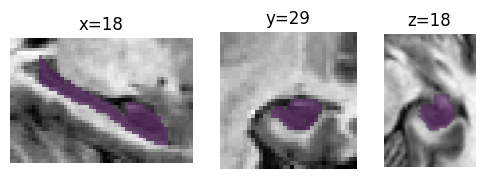

In [ ]:
displayNii(data, over=data_lab, overcut=0.0)

In [ ]:
#read all images in the path containing the training images and extract feature vectures
#cobe dimension is set to 5 x 5 x 5
Y, X, sampleIDs = create_training_set(train_path, labels_train, pdim=5)

In [ ]:
#subsample as per instructions
Xsub, Ysub, sub_idx = sub_sample(X, Y, 1000)

In [ ]:
#the initial X and Y matrices are quite large and
#clutter the memory, we don't require these for further processing
#so setting them to None and calling the garbage collector
#will preserve resources
import gc
X = None
Y = None
gc.collect()

6509

## (a) Train SVC with polynomial and RBF kernel

## (b) Apply to validation data, compute DICE and AUC

## (c) train a tree-based classifier

## (d) Explore sample size and cube dimensions

## (e) Add additional filters

## (f) Apply to test set